In [1]:
import cv2
import IPython.display
import PIL.Image
import time
from io import BytesIO
import ipywidgets as widgets

In [2]:
# gstreamer_pipeline returns a GStreamer pipeline for capturing from the CSI camera
# Defaults to 1280x720 @ 30fps
# Flip the image by setting the flip_method (most common values: 0 and 2)
# display_width and display_height determine the size of the window on the screen


def gstreamer_pipeline(
    capture_width=3280,
    capture_height=2464,
    display_width=820,
    display_height=616,
    framerate=21,
    flip_method=0,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

In [3]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def show_array(a, display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if display_id is not None:
        IPython.display.update_display(obj, display_id=display_id)
        return display_id
    else:
        return IPython.display.display(obj, display_id=True)

In [4]:
def face_detect():
    # To flip the image, modify the flip_method parameter (0 and 2 are the most common)
    print(gstreamer_pipeline(flip_method=2))
    face_cascade = cv2.CascadeClassifier(
        "/usr/share/opencv4/haarcascades/haarcascade_frontalface_default.xml"
    )
    eye_cascade = cv2.CascadeClassifier(
        "/usr/share/opencv4/haarcascades/haarcascade_eye.xml"
    )
    # Video capturing from OpenCV
    video_capture = cv2.VideoCapture(gstreamer_pipeline(flip_method=2), cv2.CAP_GSTREAMER)
    display_id = None
    fps_output = widgets.Output()
    IPython.display.display(fps_output)
    if video_capture.isOpened():
        try:
            while True:
                t1 = time.time()
                
                return_value, frame = video_capture.read()
                
                if not return_value:
                    print(f"return_value: {return_value}")
                    break
                
                # Convert the image from OpenCV BGR format to matplotlib RGB format
                # to display the image
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.3, 5)

                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    roi_gray = gray[y : y + h, x : x + w]
                    roi_color = frame[y : y + h, x : x + w]
                    eyes = eye_cascade.detectMultiScale(roi_gray)
                    for (ex, ey, ew, eh) in eyes:
                        cv2.rectangle(
                            roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2
                        )

                if display_id is not None:
                    show_array(frame, display_id)
                else:
                    display_handle = show_array(frame)
                    display_id = display_handle.display_id
                
                t2 = time.time()

                #ref: https://github.com/jupyter-widgets/ipywidgets/issues/1744#issuecomment-335179855
                with fps_output:
                    print(f"display_id: {display_id}")
                    print(f"{(1/(t2-t1)):.4f} FPS")
                    # Display the frame info until new frame is available
                    IPython.display.clear_output(wait=True)
        
        except KeyboardInterrupt as e:
            print(f"KeyboardInterrupt")
        except Exception as e:
            print(f"Exception: {e}")
        finally:
            # Release the Video Device
            video_capture.release()
            # Message to be displayed after releasing the device
            print("Released Video Resource")
    else:
        print("Unable to open camera")

nvarguscamerasrc ! video/x-raw(memory:NVMM), width=(int)3280, height=(int)2464, format=(string)NV12, framerate=(fraction)21/1 ! nvvidconv flip-method=2 ! video/x-raw, width=(int)820, height=(int)616, format=(string)BGRx ! videoconvert ! video/x-raw, format=(string)BGR ! appsink


Output()

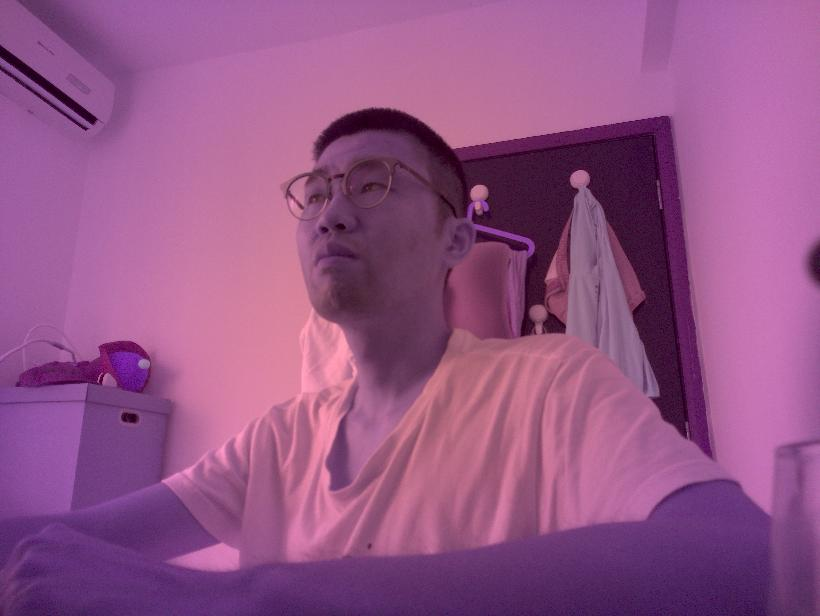

KeyboardInterrupt
Released Video Resource


In [6]:
face_detect()